We're gonna write a little code to change all the images in our dataset to size 200x200

In [1]:
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display
from PIL import Image

In [2]:
path_to_images = 'Dataset_square/'
list_images = [img for img in os.listdir(path_to_images) ]

print(list_images[:10])
print()
print(len(list_images))

['saint_bernard_188.jpg', 'german_shorthaired_15.jpg', 'german_shorthaired_136.jpg', 'Egyptian_Mau_123.jpg', 'British_Shorthair_92.jpg', 'staffordshire_bull_terrier_85.jpg', 'american_bulldog_71.jpg', 'Maine_Coon_67.jpg', 'samoyed_110.jpg', 'saint_bernard_186.jpg']

730


In [3]:
inp_loc='Dataset_square/'
out_loc='Dataset_uniform/'

cat_counter = 0
dog_counter = 0

for img_name in list_images:
    
    if img_name[0].isupper():
        img_class = 'Cat'
        counter = cat_counter
    else:
        img_class = 'Dog'
        counter = dog_counter
    
    img = ski.io.imread(os.path.join(inp_loc,img_name))        
    img = ski.transform.resize(img,(200,200),anti_aliasing=True)       
    if img.shape[2]==4:
        img = ski.color.rgba2rgb(img)
    
    img_1 = Image.fromarray((img*255).astype(np.uint8))
    img_1.save(os.path.join(out_loc,img_class+str(counter+1)+'.jpg') )
               
    counter += 1
    
    if img_class == 'Cat':
        cat_counter = counter
    else:
        dog_counter = counter

In [4]:
list_images = [img for img in os.listdir(out_loc) ]

print(list_images[:10])
print()
print(len(list_images))

['Dog157.jpg', 'Dog198.jpg', 'Dog369.jpg', 'Dog159.jpg', 'Dog122.jpg', 'Dog391.jpg', 'Cat85.jpg', 'Dog96.jpg', 'Dog127.jpg', 'Dog43.jpg']

730


We want to augment the dataset with new images created from the uniformly sized ones using small rotations and translations (separately). After implementing the transform, we shall crop out a smaller square image from the centre of the rotated (or translated) image such that we don't have any unwanted corners or edges resulting from the transform. 

In units of a 100 pixels, the images have an edge of 2 units to begin with. Let the inner square that we intend to cut out have an edge of 2z. We want to find the largest possible value of x given a certain maximum angle of rotation. If we rotate the image by (a chosen maximum angle) $\theta$ around the centre, the line from the centre to the edge of the (rotated) outer square that passes through a vertex of the inner square is $\frac{1}{\cos{\phi}}$ long, where $\phi = \frac{\pi}{4}-\theta$. Since the largest distance from the centre of the squares to the edge of the inner square is along the diagonal, to meet the condition outlined above means we need half of the diagonal i.e. $\sqrt{2}z \leq \frac{1}{\cos{\phi}}$.

We'll choose to rotate the images between $\pm 15^{\circ}$ (with a minimum magnitude of $10^\circ$) i.e. $\theta = 15^{\circ} \implies \phi = 30^\circ$. Therefore $z \leq 0.816$. So we'll choose the inner square to have an edge length of 1.6 units. And we'll choose to implement translations $\pm 0.2$ units (with a minimum magnitude of 0.1 units, along the horizontal axis only). In either case, we'll also implement a random horizontal flip to the image. 

Let's start with creating the rotated images. We shall create three new ones from each image.

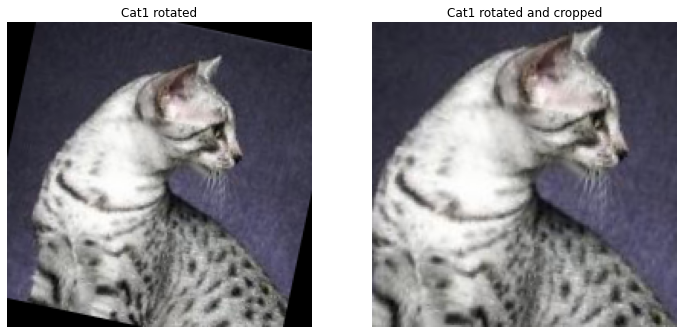

In [5]:
out_loc='Dataset_uniform/'

img_cat1 = ski.io.imread(os.path.join(out_loc,'Cat1.jpg'))

rot_angle = np.random.choice([np.random.randint(-15,-10),np.random.randint(10,15)]) 
img_cat1 = ski.transform.rotate(img_cat1,angle = rot_angle,resize=False)   #our calculation above is not consistent with resizing the rotated image to fit inside the original, we'll crop the image ourselves
if np.random.choice([True,False]):
    img_cat1 = np.flip(img_cat1,axis=1)  
    
img_cat1_crop = ski.util.crop(img_cat1, ((20,20),(20,20),(0,0)))

if img_cat1.shape[2]==4:
        img_cat1 = ski.color.rgba2rgb(img_cat1)
        img_cat1_crop = ski.color.rgba2rgb(img_cat1_crop)
        
img_cat1 = Image.fromarray((img_cat1*255).astype(np.uint8))

depic = plt.figure(figsize=(12,8))
plt.tight_layout

p = depic.add_subplot(1,2,1)
p.imshow(img_cat1)
p.set_title('Cat1 rotated')
p.axis('off')

p = depic.add_subplot(1,2,2)
p.imshow(img_cat1_crop)
p.set_title('Cat1 rotated and cropped')
p.axis('off')



plt.show()

The above is a demo of how the rotations work. Now let's have a demo of translations.

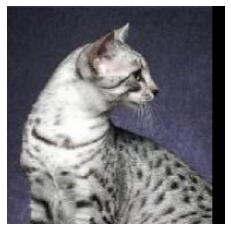

In [6]:
out_loc='Dataset_uniform/'

img_cat1 = ski.io.imread(os.path.join(out_loc,'Cat1.jpg'))

shift_val = [np.random.choice([-1,1])*(np.random.rand()+1)*10,0]  #the random number is between 1 and 2, so we multiply with 10, axis 1 is the horizontal direction as the size of the image array is 200x200
shift = ski.transform.EuclideanTransform(translation=shift_val)
img_cat1 = ski.transform.warp(img_cat1,shift)
if np.random.choice([True,False]):
    img_cat1 = np.flip(img_cat1,axis=1)    

if img_cat1.shape[2]==4:
        img_cat1 = ski.color.rgba2rgb(img_cat1)
        
img_cat1 = Image.fromarray((img_cat1*255).astype(np.uint8))



plt.imshow(img_cat1)
plt.axis('off')

plt.show()

#the cropping works just as before!

Now we shall apply the procedure above to the entire dataset. We shall define functions to implement the rotation+crop and the translation+crop.

In [7]:

def rotate_crop(pic):
    rot_angle = np.random.choice([np.random.randint(-15,-10),np.random.randint(10,15)]) 
    pic = ski.transform.rotate(pic, angle = rot_angle,resize=False) 
    if np.random.choice([True,False]):
        pic = np.flip(pic,axis=1)  
    
    pic_crop = ski.util.crop(pic, ((20,20),(20,20),(0,0)))

    if pic_crop.shape[2]==4:
        pic_crop = ski.color.rgba2rgb(pic_crop)
        
    pic_crop = Image.fromarray((pic_crop*255).astype(np.uint8))
    
    return pic_crop

def translate_crop(pic):
    shift_val = [np.random.choice([-1,1])*(np.random.rand()+1)*10,0] 
    shift = ski.transform.EuclideanTransform(translation=shift_val)
    pic = ski.transform.warp(pic,shift)
    if np.random.choice([True,False]):
        pic = np.flip(pic,axis=1)    

    pic_crop = ski.util.crop(pic, ((20,20),(20,20),(0,0)))

    if pic_crop.shape[2]==4:
        pic_crop = ski.color.rgba2rgb(pic_crop)
        
    pic_crop = Image.fromarray((pic_crop*255).astype(np.uint8))
    
    return pic_crop
    



We shall create three rotated pics and three translated pics and also downscale the original to the new dimensions to create seven pics from each pic in the dataset.

In [12]:
cat_counter = 0
dog_counter = 0

out_loc='Dataset_uniform/'
final_loc = 'Dataset_aug/'

img_list = [img for img in os.listdir(out_loc) ]

for img_name in img_list:
    
    if img_name[0] == 'C':
        img_class = 'Cat'
        counter = cat_counter
    else:
        img_class = 'Dog'
        counter = dog_counter
        
    img = ski.io.imread(os.path.join(out_loc,img_name))
    img_rs = ski.transform.resize(img,(160,160),anti_aliasing=True)       
    if img_rs.shape[2]==4:
        img_rs = ski.color.rgba2rgb(img_rs)
    
    img_rs = Image.fromarray((img_rs*255).astype(np.uint8))
    img_rs.save(os.path.join(final_loc,img_class+'_'+str(counter+1)+'.jpg') )
    counter += 1
    
    for i in range(3):
        img_r = rotate_crop(img)
        img_r.save(os.path.join(final_loc,img_class+'_'+ str(counter+1) + '.jpg') )
        counter += 1

        img_t = translate_crop(img)
        img_t.save(os.path.join(final_loc,img_class+'_'+ str(counter+1) + '.jpg') ) 
        counter += 1
        
    if img_class == 'Cat':
        cat_counter = counter
    else:
        dog_counter = counter
            
